# Chapter 3 - CLASSIFICATION

This notebook contains the code for chapter 3

In [15]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Get the data

In [20]:
# Importing the data

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [21]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [22]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

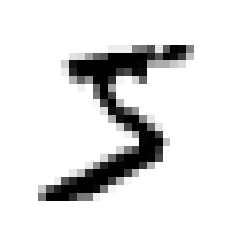

In [25]:
# Visualise one value 
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [26]:
# Check label
y[0]

'5'

In [27]:
# Convert to num type
y = y.astype(np.uint8)

In [28]:
# Split train and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Binary classifier training

In [31]:
# Convert labels into true/false
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Using Stochastic Gradient Descent Classifier

In [32]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Test predictions

In [34]:
sgd_clf.predict([some_digit])

array([ True])

Prediction correct for this specific example

### Performance measure

#### 1. Measuring accuracy using cross validation

In [36]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Not a good measure, expecially for skewed data. 

#### 2. Confusion matrix

Make prediction using the `cross_val_predict()` function and generating a `confusion_matrix()`

* Row: actual class
* Column: predicted class

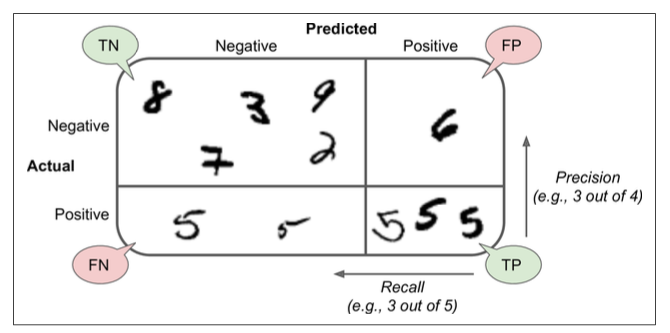

In [38]:
# Make predictions
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [40]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]])

* **Precision (PPV)**: TP/(TP+FP)

* **Recall (PPA/TPR)**: TP/(TP+FN)

* **F1**: harmonic mean 

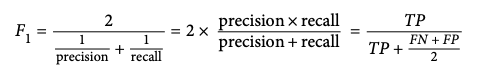

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_train_5, y_train_predict)
recall = recall_score(y_train_5, y_train_predict)
f1 = f1_score(y_train_5, y_train_predict)

precision, recall, f1

(0.8370879772350012, 0.6511713705958311, 0.7325171197343846)

Use the `decision_function()` to return a score per each instance and use a threshold to make predictions based on the scores

>Predict confidence scores for samples. The confidence score for a sample is proportional to the signed distance of that sample to the hyperplane.

In [44]:
# Get score
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [47]:
# Add threshold
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [48]:
# Increase threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Increasing the threshold decrease the recall. 

**How to chose the threshold?**

* `cross_val_predict()`: get the scores of the instances of the training set, returning *decision scores* instead of predictions. 
* `precision_recall_curve()`: compute precision and recall for possible thresholds

In [49]:
# Get decision scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [52]:
# Compute precision, recall, thresholds
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Plot precision and recall vs threshold

Saving figure precision_recall_vs_threshold_plot


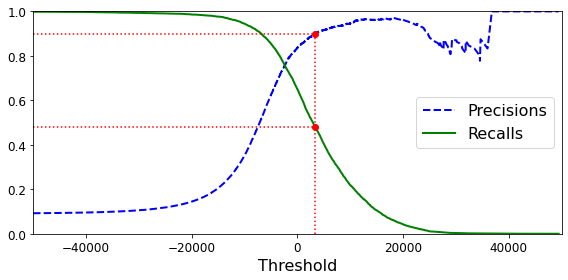

In [82]:
# Plot curves
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precisions', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label="Recalls", linewidth=2)
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel('Threshold', fontsize=16)
    #plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8,4))
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")              
plt.show()

Plot precision vs recall

Saving figure precision_vs_recall_plot


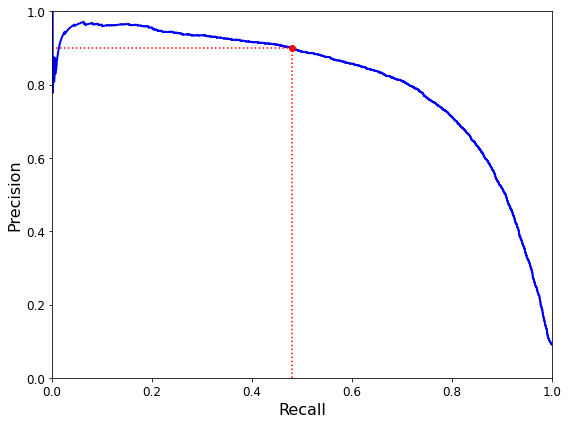

In [78]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    #plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

* Define precision level i.e. 90%
* Search for the lowest threshold that gives you at least 90% precision
* `np.argmax()`: get the first index of the maximum value, in this case the first True value for a certain precision 

In [81]:
# Get threshold from precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [84]:
# Make predicions using the identified theshold 
y_train_pred_90 = (y_scores > threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [85]:
# Calculate precision, recall and f1

precision_90 = precision_score(y_train_5, y_train_pred_90)
recall_90 = recall_score(y_train_5, y_train_pred_90)
f1_90 = f1_score(y_train_5, y_train_pred_90)

precision_90, recall_90, f1_90

(0.9, 0.47980077476480354, 0.625917458789556)

You can obtain high precision, but recall can be low. 

#### 3. ROC curve

Receiver Operating Characteristics curve. 

True positive rate (TPR) vs false positive rate (FPR)

* TPR = recall
* FPR = 1 - specificity (True negative rate): ratio of negative instances that are incorrectly classified as positive
* TNR = ratio of negative instances that are correctly classified as negative


Use `roc_curve()` to calculate  TPR, FPR and thresholds.

In [87]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


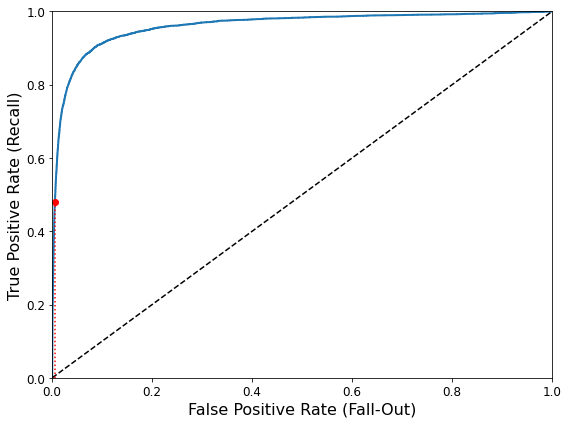

In [89]:
# Plot ROC curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    #plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]         
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

Trade-off between TPR and FPR. 

Compare classifiers by calculating the Area Under the Curve using the function `roc_auc_score()`.

In [92]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Test RandomForestClassifier to compare different classifiers. 

This classifier has the function `predict_proba()` instead of `decision_function()`

In [93]:
# Instantiate classifiers and get prediction scores
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                   method='predict_proba')

In [99]:
# Give class probabilities instead of scores 
y_forest_scores = y_probas_forest[:, 1]
y_forest_scores.shape

(60000,)

In [103]:
# Calculating parameters for ROC curve
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_forest_scores)

Saving figure roc_curve_comparison_plot


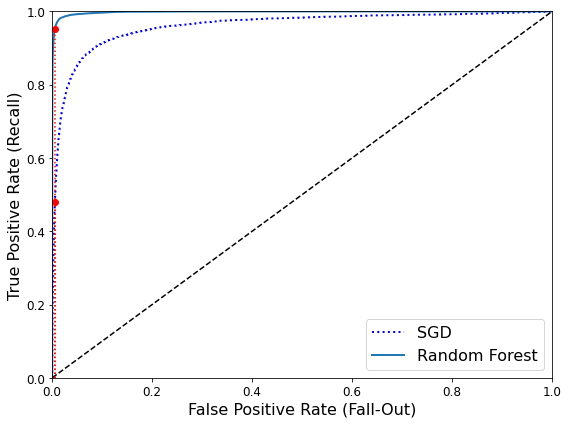

In [105]:
# Plot the curves
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
#plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [106]:
# Calculate auc
roc_auc_score(y_train_5, y_forest_scores)

0.9983436731328145

### Multiclass classification

Algorithm that can handle mutliple classes: 
* SGD classifiers
* Random Forest classifiers
* naive Bayes classifiers

Strictly binary classifiers: 
* Logistic Regression
* Support Vector Machine

**Strictly binary** 

*Strategies:*
* One versus the rest (OvR)
* One versus one (OvO)

Scikit learn automatically detects a multiclassification task and un OvR or OvO.


Test Support Vector Machine Classifier

In [108]:
# Instantiate and fit classifier, and make predictions
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Scikit learn used the OvO strategy. Using the `decision_function()` to obtain score for each class

In [111]:
# Get score
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

The classifier stores the class list in the `classes_` attribute

In [113]:
# Get the class list
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [112]:
# Get the class with the highest value
np.argmax(some_digit_scores)

5

In [116]:
# Get the class value
svm_clf.classes_[np.argmax(some_digit_scores)]

5

To force Scikit learn to use a specified strategy use `OneVsOneClassifier()` or `OneVsRestClassifier()`.

In [117]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [118]:
# Check the number of classes
len(ovr_clf.classes_)

10

**Multiple classes algorithm**

No strategy selection as they can handle multiple classes classification

In [119]:
# Using SGD Classifier - no need to instantiate as done above
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [120]:
# Get values per each class
some_digit_sgd_scores = sgd_clf.decision_function([some_digit])
some_digit_sgd_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Evaluate the model using accuracy using `cross_val_score()`

In [121]:
# Get model accuracy 
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

The accuracy is ~85%, not very high and can be improved. Try scaling the inputs with `StandardScaler()` (as shown in **chapter 2**)

In [122]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [123]:
# Evaluate the model on the scaled data set
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### Error analysis

After following all the standard pipeline step to identify a promising model, analyse the type of errors to improve it. 

**Confusion matrix**

In [124]:
# Make predictions

y_trained_predict = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

# Ouput below wrong (wrong y_pred used to plot)

array([[5860,   63,    0,    0,    0,    0,    0,    0,    0,    0],
       [6675,   67,    0,    0,    0,    0,    0,    0,    0,    0],
       [5932,   26,    0,    0,    0,    0,    0,    0,    0,    0],
       [5913,  218,    0,    0,    0,    0,    0,    0,    0,    0],
       [5821,   21,    0,    0,    0,    0,    0,    0,    0,    0],
       [1891, 3530,    0,    0,    0,    0,    0,    0,    0,    0],
       [5796,  122,    0,    0,    0,    0,    0,    0,    0,    0],
       [6251,   14,    0,    0,    0,    0,    0,    0,    0,    0],
       [5741,  110,    0,    0,    0,    0,    0,    0,    0,    0],
       [5903,   46,    0,    0,    0,    0,    0,    0,    0,    0]])

In [126]:
# Generate confusion matrix
conf_mx = confusion_matrix(y_train, y_trained_predict)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Represent the matrix with the `matshow()` function or `plot_confusion_matrix()` 

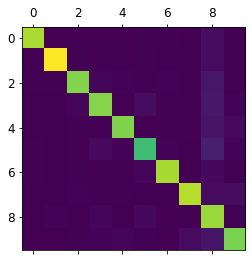

In [137]:
# Plot matrix
plt.matshow(conf_mx)
plt.show()

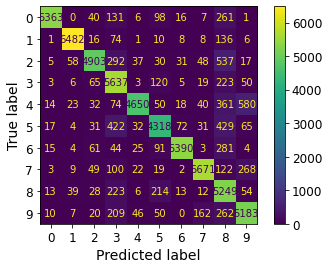

In [129]:
# Plot using sklearn function 
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(sgd_clf, X_train, y_train)

Most images are on the diagonals, good predictions. 

The 5s are slightly darker than the others: 
* fewer 5 in the dataset
* worse performance for 5

Normalise for the number of images in each class to compute error rates. 

In [130]:
# Get the total number of images per class
row_sums = conf_mx.sum(axis=1, keepdims=True)

# Normalisation
norm_conf_mx = conf_mx / row_sums

To visualise only the error, replace the diagonal (correct matches) with 0

In [132]:
# Fill diagonal
np.fill_diagonal(norm_conf_mx, 0)

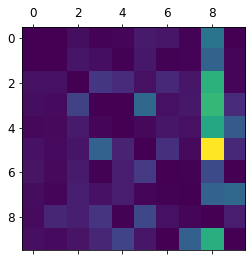

In [136]:
# Plot the matrix

plt.matshow(norm_conf_mx)
plt.show()

Analyse the errors: 
* Light column 8: many images gets wrongly classified as 8
* Row 8 ok: 8s correctly classified
* Confusion between 3s and 5s

### Multilabel classification

Output multiple classes (binary tags) for each instance.

`KNeighborsClassifier` supports multilabel classification.

Exmple: large and odd number

In [138]:
# Create output labels
y_train_large = (y_train >= 7)
y_train_odd =(y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [139]:
# Instantiate and fit the KNeighborsClassifier 
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [140]:
# Predict
knn_clf.predict([some_digit])

array([[False,  True]])

**Evaluation**

Depending on the progect, there are different ways of evaluating a multilabel classifier. 

Example: average of F1 score of each label. 

In [141]:
# Make prediction with the whole data set
y_train_knn_predict = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [142]:
# Calculating f1 score
f1_score(y_multilabel, y_train_knn_predict, average='macro')

0.976410265560605

Assumption that all labels are equally important. 

Use `average=weighted` to give each label a weight equal to its support (i.e. number of instances with the target label).

### Multioutput classification

Generalisation of multilabel classification where each label can be multiclass (i.e. it can have more than two possible values). 

Example: noise removal from images (array of pixel intensities) 
* Input: noisy digital image
* Output: clean digital image 
    * Multilabel: one label per pixel
    * Each label can have multiple values (0, 255)
    
Generate the training set by adding noise to the MNIST images with the `np.random.randint()` function. 

In [146]:
# Generate noise train
noise = np.random.randint(0, 100, (len(X_train), 784))
# Add noise to train images
X_train_mod = X_train + noise

# Generate noise test
noise = np.random.randint(0, 100, (len(X_test), 784))
# Add noise to test images
X_test_mod = X_test + noise

# Assig the original value as labels
y_train_mod = X_train
y_test_mod = X_test

In [148]:
# Train the knn classifier
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [152]:
# Make predictions (can be plotted)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

## Excercises 

**Question 1**: Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters).

In [153]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [154]:
# Define parameters for grid search
param_grid = [{
    'weights': ['uniform', 'distance'], 
    'n_neighbors': [3, 4, 5]
}]

In [155]:
# Instantiate and fit grid search
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time= 1.3min
[CV] END .....................n_neighbors=3, weights=uniform; total time= 1.5min
[CV] END .....................n_neighbors=3, weights=uniform; total time=  52.3s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  46.1s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  44.9s
[CV] END ....................n_neighbors=3, weights=distance; total time=  49.6s
[CV] END ....................n_neighbors=3, weights=distance; total time=  48.8s
[CV] END ....................n_neighbors=3, weights=distance; total time=  49.2s
[CV] END ....................n_neighbors=3, weights=distance; total time=  46.4s
[CV] END ....................n_neighbors=3, weights=distance; total time=  49.3s
[CV] END .....................n_neighbors=4, weights=uniform; total time=  46.0s
[CV] END .....................n_neighbors=4, weig

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=2)

In [156]:
# Get best parameters
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [158]:
# Get the best score
grid_search.best_score_

0.9716166666666666

In [230]:
# Make predictions
grid_search.predict(X_test)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 12 while Y.shape[1] == 784

In [231]:
# Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

NameError: name 'y_pred' is not defined

**Question 2**: Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel^. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called *data augmentation* or *training set expansion*.

^You can use the `shift()` function from the `scipy.ndimage.interpolation` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right.

In [161]:
from scipy.ndimage.interpolation import shift

In [169]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

Test the function on one image

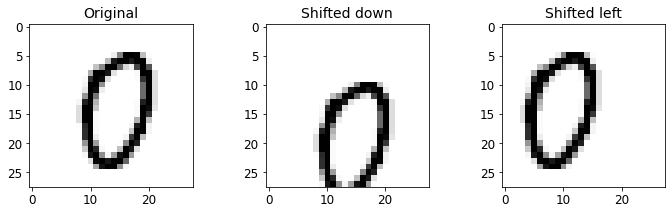

In [170]:
# Select one image
image = X_train[1000]

# Shift image
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

# Plot
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

Use the function to modify every image in the 4 directions

In [187]:
# Make lists
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

# Transform
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

# Make arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

KeyboardInterrupt: 

In [ ]:
# Shuffle the sets
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
# Istantiate estimator
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

# Fit
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
# Make predictions
y_preds = knn_clf.predict(X_train)

In [ ]:
# Evaluate
accuracy_score(y_test, y_preds)

**Question 3**: Tackle the Titanic dataset.

Use the data from the Titanic challenge in [Kaggle](https://www.kaggle.com/c/titanic). 

Objective: predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

**Get the data**

The data is saved in `dataset\titanic`, define a function to automatically import the data. 

In [175]:
import os
import pandas as pd

In [176]:
# Define data path 
TITANIC_PATH = os.path.join("datasets", "titanic")

In [177]:
# Define import function
def import_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [178]:
# Import files
train_data = import_titanic_data('train.csv')
test_data = import_titanic_data('test.csv')

The data is already split into a training set and a test set. However, the test data does *not* contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

**Explore the data**

In [181]:
train_data.shape

(891, 12)

In [179]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Attributes meaning: 
* **survival**: Target (0 = No, 1 = Yes)
* **pclass**: Ticket class (1st, 2nd, 3rd)
* **Name, sex, age**: self exlanatory	
* **sibsp**: # of siblings/spouses aboard the Titanic	
* **parch**: # of parents/children aboard the Titanic	
* **ticket**: Ticket number	
* **fare**: Passenger fare	
* **cabin**: Cabin number	
* **embarked**: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

Check for missing data

In [183]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Missing data: 
* Age --> compute median
* Cabin --> ignore
* Embarked --> decide later

Check numerical attributes

In [184]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Check survival data to define evaluation metrics

In [185]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

38% **Survived**, that's close enough to 40%, so *accuracy* will be a reasonable metric to evaluate our model. 

For categorical attributes: 
* **Name** and **Ticket** will have to many values and will be ignored for now

Analyse the other attributes

In [188]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [189]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [191]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

**Prepare the data**

* Numerical attributes: impute median
* Categorical attributes: OneHotEncoder

In [196]:
# Select attributes
num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

In [197]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Define the numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

The `SimpleImputer` does not work for categorical values, one option is to convert them to numbers, fill na with the most frequent value, then convert them back.

Otherwise write a function to fill na with most frequent value. 

In [198]:
from sklearn.base import BaseEstimator, TransformerMixin

# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [199]:
from sklearn.preprocessing import OneHotEncoder

# Define categorical pipeline

cat_pipeline = Pipeline([
    ('imputer', MostFrequentImputer()), 
    ('cat_encoder', OneHotEncoder(sparse=False))
])

In [201]:
# Construct column transformer
from sklearn.compose import ColumnTransformer

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs), 
    ('cat', cat_pipeline, cat_attribs)
])

In [209]:
# Split the train set into X and Y
X_train_raw = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']

In [210]:
# Fit pipeline to train data
X_train = preprocess_pipeline.fit_transform(X_train_raw)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

**Training models**

In [212]:
# Preprocess the test set
X_test = preprocess_pipeline.transform(test_data)

*SVC*

In [211]:
# Instantiate and train the model
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [213]:
# Make predictions
y_preds = svm_clf.predict(X_test)

In [215]:
# Evaluate the model
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

*RandomForestClassifier*

In [217]:
# Instantiate and train the model
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [220]:
# Evaluate model
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

Plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles

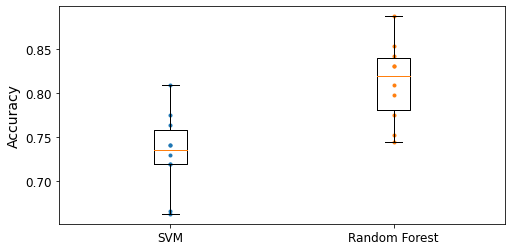

In [223]:
# Plot scores
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

To improve this result further, you could:
* Compare many more models and tune hyperparameters using cross validation and grid search,
* Do more feature engineering, for example:
  * replace **SibSp** and **Parch** with their sum,
  * try to identify parts of names that correlate well with the **Survived** attribute (e.g. if the name contains "Countess", then survival seems more likely),
* try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates, so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived.

**Question 4**: Build a spam classifier:
* Download examples of spam and ham from [Apache SpamAssassin’s public datasets](https://spamassassin.apache.org/old/publiccorpus/).
* Unzip the datasets and familiarize yourself with the data format.
* Split the datasets into a training set and a test set.
* Write a data preparation pipeline to convert each email into a feature vector. 
    * Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1] (meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word.
    * You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL,” replace all numbers with “NUMBER,” or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this).
    * Finally, try out several classifiers and see if you can build a great spam classi‐ fier, with both high recall and high precision.
    
**Get the data**

In [224]:
import os
import tarfile
import urllib.request

In [225]:
# Define paths
DOWNLOAD_ROOT = 'https://spamassassin.apache.org/old/publiccorpus/'
HAM_URL =  DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join('datasets', 'spam')

In [226]:
# Define functions
def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [227]:
# Download data
fetch_spam_data()

In [228]:
# Import data
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

**Explore the data**

In [229]:
len(ham_filenames), len(spam_filenames)

(2500, 500)